# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## <font color ='TURQUOISE'>Импорт модулей</font>

In [66]:
%%time
%%capture

import numpy as np 
import pandas as pd
import gc
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', 2)
 # Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 # Сброс ограничений на количество символов в записи
# pd.set_option('display.max_colwidth', None)
# При записи изменённых признаков в исходный датафрейм код может вызывать предупреждение SettingWithCopy.
# Причина в особенности поведения sklearn и pandas. 
# Чтобы предупреждение не появлялось, в код добавляют строчку:
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
%matplotlib inline
import math
from math import factorial, exp
from scipy import stats as st
import seaborn as sns
import warnings

from scipy.stats import binom #помогает получить вероятности биномиального распределения
from scipy.stats import poisson #значения функции распределения для распределения Пуассона

from ipywidgets import IntProgress
from IPython.display import display
import time
import datetime
# Помогаторные функции
def кп(текст): #красный подчеркнутый
    return f"\033[31m\033[4m{текст}\033[0m"
def сп(текст): #синий подчеркнутый
    return f"\033[34m\033[4m{текст}\033[0m"
def з(текст): #синий подчеркнутый
    return f"\033[32m{текст}\033[0m"
pd.set_option('display.float_format', '{:.2f}'.format)
def print_df(df):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        warnings.filterwarnings('ignore')
        display(HTML(df.to_html()))
def t():
    return datetime.datetime.now()

import random
def цвет():
    return f'rgb({random.randrange(255)},{random.randrange(255)},{random.randrange(255)})'

def info_df(df):
    print(f'запуск проверки {сп(t())}, на моент запуска {сп(len(df))} строк')
    дубликатов = df.duplicated().sum()
    if дубликатов >= 1:
        print(кп('Найдены дубликаты:'))
        print(df.value_counts())
        print(f'Нужно удалить {кп(дубликатов)} дублей')
    строк = df.reset_index()['index'].count()
    print(з(df.info()))
    display(df.describe())    
    if строк>3:
        display(df.sample(3))
    else:
        print(f"Набор данных содержит {кп(строк)} строк. Вывожу весь набор данных")
        display(df.sample(строк))

def f1():
    print(f'''
{сп('1. Функции вызова')}
    1.1 {з('print_df(df)')} - выводит набор данных полностью
    1.5 {з('t()')} - выводит текущую дату и время
    1.6 {з('цвет()')} - выводит цветовую палитру, пример rgb(7,40,89)
{сп('2. Визуализация данных')}
    2.1 {з('info_df(df):')} - выводит информацию о данных (.info()), проверяет наличие дублей (.duplicated().sum()), если они есть, то предупреждает о них, описывает числительные данные (.describe()).
    2.2 {з('диаграмма(df, target, col, x, name):')} - выводит диаграмму, target - значение по оси ординат, x - значение по оси абсцисс, col - поле содержащее информацию о легенде, name -наименование графика.
    2.3 {з('boxplot(df, target, col, name):')} - выводит boxplot, target - значение по оси ординат, x - значение по оси абсцисс, col - поле содержащее информацию о легенде, name -наименование графика.
    2.4 {з('линия(df, target, x, name='', legend=0, col=''):')} - выводит линейный график, target - значение по оси ординат, x - значение по оси абсцисс, col - поле содержащее информацию о легенде, name -наименование графика. legend=0 означает, что легенда на графике не нужна, а значит не нужно указывать параметр col
    2.5 {з('гистограмма(df, target, col, name):')} - выводит гистограмму, target - значение по оси ординат, x - значение по оси абсцисс, col - поле содержащее информацию о легенде, name -наименование графика.
    2.6 {з('кп(текст)')} - цвет красный подчеркнутый
    2.7 {з('сп(текст)')} - цвет синий подчеркнутый
    2.8 {з('з(текст)')} - цвет зеленый
    ''')
#
# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


from sklearn.model_selection import train_test_split




def наборы_обучения(df, целевой_признак, p = 1):
    train = df.drop(целевой_признак, axis=1)
    valid = df[целевой_признак]
    features_train, features_valid_all, target_train, target_valid_all = train_test_split(
        train, valid, test_size=0.4, random_state=12345)
    features_valid, features_test, target_valid, target_test = train_test_split(
            features_valid_all, target_valid_all, test_size=0.5, random_state=12345)
    return features_train, features_valid, features_test, target_train, target_valid, target_test
    if p ==1:
        print('Размеры исходных датафреймов')
        print('Загруженный файл', df.shape)
        print('features_train', features_train.shape)
        print('features_valid_all', target_valid_all.shape)
        
        print('features_valid', features_valid.shape)
        print('features_test', features_test.shape)
    


from sklearn.preprocessing import StandardScaler #стандартизация данных
from sklearn.metrics import f1_score
# Полнота и точность оценивают качество прогноза положительного класса с разных позиций.
# Recall описывает, как хорошо модель разобралась в особенностях этого класса и распознала его.
# Precision выявляет, не переусердствует ли модель, присваивая положительные метки. 
# когда полнота или точность близки к нулю, то к 0 приближается и само среднее гармоническое
# Единица в F1 означает, что соотношение полноты и точности равно 1:1
# Если положительный класс плохо прогнозируется по одной из шкал (Recall или Precision), 
# то близкая к нулю F1-мера покажет, что прогноз класса 1 не удался.



from sklearn.utils import shuffle



def строковые_столбцы(df):
    цифровые_столбцы = []
    for coll in df.columns:
        if df[coll].dtypes=="object":
            цифровые_столбцы += [coll]
    return цифровые_столбцы

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, r2_score

def зкште(trt):
    return print(trt)

CPU times: user 14.5 ms, sys: 0 ns, total: 14.5 ms
Wall time: 13.7 ms


## Загрузите и подготовьте данные. Поясните порядок действий.

In [67]:
print(t())
df_Churn = pd.read_csv(r'/datasets/Churn.csv')
info_df(df_Churn)

целевой_признак = 'Exited'

2023-10-22 16:30:32.964656
запуск проверки 2023-10-22 16:30:33.007452, на моент запуска 10000 строк
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,9091.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
...,...,...,...,...,...,...,...,...,...,...,...
max,10000.00,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7937,7938,15775886,Su,670,France,Male,36,NaN,0.00,1,1,0,140754.19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8580,8581,15801915,Rendall,529,France,Female,31,6.00,152310.55,1,1,0,13054.25,0


##### Промежуточные выводы
В данных 10000 строк, встречаются текстовые форматы данных.
Столбец "Tenure" — сколько лет человек является клиентом банка в некоторых случаях не заполнен.
Целевой столбец "Exited"— факт ухода клиента имет формат "int64", заполнен во всех случаях.
Полагаю, что столбцы 'Surname', 'CustomerId', 'RowNumber' малозначимы для подготовки моделей, более того, они могут ухудшить результаты.

In [68]:
df_Churn = df_Churn.drop(['Surname', 'CustomerId', 'RowNumber'], axis=1)

## Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.

###  Обучим модель регрессии на исходных данных

In [4]:
%%time
print(t())

features_train, features_valid, features_test, target_train, target_valid, target_test = (
    наборы_обучения(df_Churn, целевой_признак))
try:
    model = LogisticRegression()
    model.fit(features_train, target_train)
    print(з('Обучение удалось'))
except Exception as e:
    print(кп('Ошибка выполнения'))
    print(сп(e))
    print(сп(df_Churn.dtypes))

2023-10-22 12:05:37.813999
Ошибка выполнения
could not convert string to float: 'Spain'
CreditScore    int64
               ...  
Exited         int64
Length: 11, dtype: object
CPU times: user 5.44 ms, sys: 4.4 ms, total: 9.84 ms
Wall time: 8.82 ms


##### Промежуточный вывод
Принадлежность к категории логистическая регрессия вычисляет по формуле, состоящей из признаков. Они могут быть только численные. Наши данные содержали и категориальные признаки тоже — в этом и есть ошибка.<br>
Чтобы это побороть, применяю метод прямого кодирования One-Hot Encoding, этот метод подходит для всех типов моделей. Метод Ordinal Encoding не подходит для логистической регрессии.

### Применяю прямое кодирование ко всему датафрейму One-Hot Encoding

In [69]:
data_ohe = pd.DataFrame()
data_ohe = data_ohe.append(pd.get_dummies(df_Churn, drop_first=True))
print(data_ohe.info())
print(f'Было строк {len(df_Churn)} стало строк {len(data_ohe)}')
display(data_ohe)
display(df_Churn)
display(строковые_столбцы(data_ohe))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             9091 non-null   float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB
None
Было строк 10000 стало строк 10000


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.00,0.00,1,1,1,101348.88,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9999,792,28,NaN,130142.79,1,1,0,38190.78,0,0,0,0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.00,0.00,1,1,1,101348.88,1
...,...,...,...,...,...,...,...,...,...,...,...
9999,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


[]

##### промежуточный выод
Таблица стала шире. Транспонировались столбцы: Geography, Surnameб Gender.
Количество строк осталось без изменений. В data_ohe отсутствуют строковые столбцы.

### Стандартизация данных

In [72]:
%%time
print(t())
features_train, features_valid, features_test, target_train, target_valid, target_test = (
#     наборы_обучения(data_ohe.fillna(0), целевой_признак))
    наборы_обучения(data_ohe.fillna(3), целевой_признак))
# Создадим объект этой структуры и настроим его на обучающих данных. Настройка — это вычисление среднего и дисперсии:
scaler = StandardScaler()
scaler.fit(features_train)



# Преобразуем обучающую и валидационную выборки функцией transform().
# Изменённые наборы сохраним в переменных: features_train_scaled (англ. «масштабированные признаки для обучения»)
# и features_valid_scaled (англ. «масштабированные признаки для проверки»):

features_train_scaled = pd.DataFrame(data=scaler.transform(features_train), columns=features_train.columns)
features_valid_scaled = pd.DataFrame(data=scaler.transform(features_valid), columns=features_train.columns)
features_test_scaled = pd.DataFrame(data=scaler.transform(features_test), columns=features_train.columns)
display(features_train_scaled)

2023-10-22 16:32:27.743782


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,-0.89,-0.37,1.12,1.23,-0.89,0.64,-1.06,-0.19,-0.57,1.73,0.91
...,...,...,...,...,...,...,...,...,...,...,...
5999,0.40,-0.09,-1.37,-1.23,0.83,-1.56,-1.06,-0.95,-0.57,-0.58,0.91


CPU times: user 30.6 ms, sys: 3.83 ms, total: 34.4 ms
Wall time: 36.9 ms


##### промежуточный выод
Есть немного странные данные, но зато теперь масштаб у всех признаков теперь одинаковый.

### Проверка адекватности модели

In [74]:
%%time
print(t())

# features_train_scaled
# features_valid_scaled


try:
    model = DecisionTreeClassifier(random_state=12345, max_depth=10)
    model.fit(features_train_scaled, target_train)
    print(з('Обучение удалось'))
    predicted_valid = model.predict(features_valid_scaled)
    accuracy_score = accuracy_score(target_valid, predicted_valid)
    print(f'''Точность модели {f'{accuracy_score*100:.2f}%'}''')
except Exception as e:
    print(кп('Ошибка выполнения'))
    print(сп(e))

2023-10-22 16:33:06.098296
Обучение удалось
Точность модели 83.45%
CPU times: user 27.9 ms, sys: 244 µs, total: 28.1 ms
Wall time: 25.7 ms


##### промежуточный выод
Доля правильных ответов — 83%

### Исследуем целевой признак

Распределение целевого признака Exited


0   0.80
1   0.20
Name: Exited, dtype: float64

<AxesSubplot:>

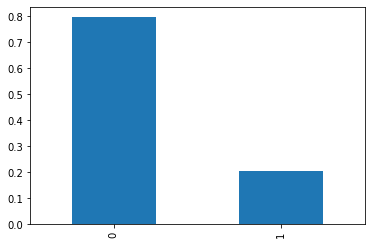

In [75]:
print(f'Распределение целевого признака {целевой_признак}')
class_frequency = data_ohe[целевой_признак].value_counts(normalize=True)
display(class_frequency)
class_frequency.plot(kind='bar')

##### промежуточный выод
Наблюдаю сильный дисбаланс целевого признкака. Проанализирую частоты классов в результатах предсказаний решающего дерева.

частоты классов в результатах предсказаний решающего дерева


0   0.69
1   0.31
dtype: float64

<AxesSubplot:>

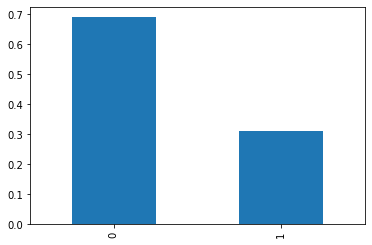

In [9]:
class_frequency = pd.Series(predicted_valid).value_counts(normalize=True)
print('частоты классов в результатах предсказаний решающего дерева')
display(class_frequency)
class_frequency.plot(kind='bar')

##### промежуточный выод
Аналогичный дисбаланс и в предсказании. Создам константную модель и проверю предсказания на ней.

### Вывод раздела
Точность константной модели 80%, что почти схоже с текущей моделью.
<br> <b>вывод точность на адекватность модель не прошла.</b>

## Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.

### Взвешивание классов

In [77]:
try:
    model = LogisticRegression(random_state=12345, solver='liblinear')
    model.fit(features_train_scaled, target_train)
    print(з('Обучение удалось'))
    predicted_valid = model.predict(features_valid_scaled)
    f1мера = f1_score(target_valid, predicted_valid)
    print(f'F1-мера до перераспределения веса целевого признака: {round(f1мера*100, 2)}%')
    accuracy_score = accuracy_score(target_valid, predicted_valid)
    print(f'''Точность модели {accuracy_score}%''')
    
    model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
    model.fit(features_train_scaled, target_train)
    print(з('Обучение удалось'))
    predicted_valid = model.predict(features_valid_scaled)
    f1мера = f1_score(target_valid, predicted_valid)
    print(f'F1-мера после перераспределения веса целевого признака: {f"{round(f1мера*100, 2)}%"}')
    
    accuracy_score = accuracy_score(target_valid, predicted_valid)
    print(f'''Точность модели {round(accuracy_score*100, 2)}%''')
    
except Exception as e:
    print(кп('Ошибка выполнения'))
    print(сп(e))

Обучение удалось
F1-мера до перераспределения веса целевого признака: 33.28%
Ошибка выполнения
'numpy.float64' object is not callable


##### Промежуточный вывод
F1-мера далека от 1, это означает, что положительный класс плохо прогнозируется по одной из шкал (Recall или Precision). Стоит отметить, что после взвешивания классов F1-мера подросла.

In [12]:
try:
    accuracy_score(pd.Series([1,0,1,0,1,1,1,0,1,0]).astype('float64'), pd.Series([1,1,1,0,1,1,1,0,1,0]).astype('float64'))
except Exception as e:
    print(кп('Ошибка выполнения'))
    print(сп(e))

Ошибка выполнения
'numpy.float64' object is not callable


In [13]:
try:
    accuracy_score(pd.Series([1,0,1,0,1,1,1,0,1,0]).astype('int'), pd.Series([1,1,1,0,1,1,1,0,1,0]).astype('int'))
except Exception as e:
    print(кп('Ошибка выполнения'))
    print(сп(e))

Ошибка выполнения
'numpy.float64' object is not callable


In [14]:
try:
    accuracy_score(pd.Series([1,0,1,0,1,1,1,0,1,0]).astype('double'), pd.Series([1,1,1,0,1,1,1,0,1,0]).astype('double'))
except Exception as e:
    print(кп('Ошибка выполнения'))
    print(сп(e))

Ошибка выполнения
'numpy.float64' object is not callable


### Увеличение выборки

In [15]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Распределение целевого признака Exited


0   0.80
1   0.20
Name: Exited, dtype: float64

<AxesSubplot:>

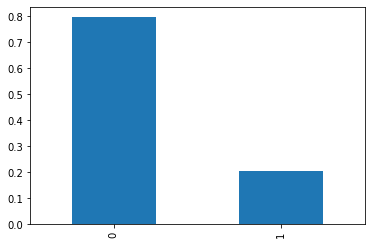

In [16]:
print(f'Распределение целевого признака {целевой_признак}')
class_frequency = df_Churn[целевой_признак].value_counts(normalize=True)
display(class_frequency)
class_frequency.plot(kind='bar')

F1-мера после перераспределения веса целевого признака: 42.48%
F1-мера после увеличения выборки: 43.61%. Выборка увеличена в 3 раз.
Распределение целевого признака Exited


0   0.57
1   0.43
Name: Exited, dtype: float64

CPU times: user 8.3 s, sys: 1.43 s, total: 9.72 s
Wall time: 9.73 s


<AxesSubplot:>

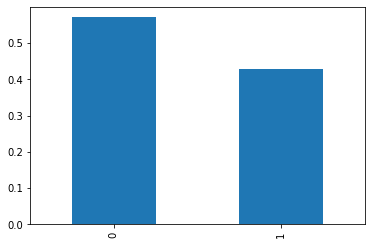

In [19]:
%%time
data_ohe = pd.DataFrame()
data_ohe = data_ohe.append(pd.get_dummies(df_Churn.fillna(0), drop_first=True))

target = data_ohe[целевой_признак]
features = data_ohe.drop(целевой_признак, axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)


лучшее_повторение = 2
print(f'F1-мера после перераспределения веса целевого признака: {f"{round(f1мера*100, 2)}%"}')
f1мера_1=0
for i in range(2,20):
#     print(i)
    gc.collect()
    features_upsampled, target_upsampled = upsample(features_train, target_train, i)
    model = LogisticRegression(solver='liblinear', random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    f1мера_1 = f1_score(target_valid, predicted_valid)
    if f1мера_1>f1мера:
        f1мера=f1мера_1
        лучшее_повторение = i
        features_train = features_upsampled.copy()
        target_train = target_upsampled.copy()
    del features_upsampled, target_upsampled
    gc.collect()
print(f'F1-мера после увеличения выборки: {f"{round(f1мера*100, 2)}%"}. Выборка увеличена в {лучшее_повторение} раз.')
print(f'Распределение целевого признака {целевой_признак}')
class_frequency = pd.Series(target_train).value_counts(normalize=True)
display(class_frequency)
class_frequency.plot(kind='bar')

Распределение целевого признака Exited


1   0.50
0   0.50
Name: Exited, dtype: float64

<AxesSubplot:>

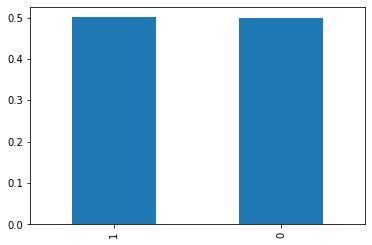

In [79]:
data_ohe = pd.DataFrame()
data_ohe = data_ohe.append(pd.get_dummies(df_Churn.fillna(0), drop_first=True))

target = data_ohe[целевой_признак]
features = data_ohe.drop(целевой_признак, axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

scaler = StandardScaler()
scaler.fit(features_upsampled)
features_train_scaled = pd.DataFrame(data=scaler.transform(features_upsampled), columns=features_upsampled.columns)


print(f'Распределение целевого признака {целевой_признак}')
class_frequency = pd.Series(target_upsampled).value_counts(normalize=True)
display(class_frequency)
class_frequency.plot(kind='bar')

##### Промежуточный вывод
F1-мера все еще далека от 1. Путем увеличения выборки при 4 повтарениях достигнуто равновесие по целевому признаку. Попробуем обратный путь - уменьшение отрицательных ответов, возможно выкинув лишнее модель станет лучше предсказывать.

### Уменьшение выборки

In [22]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

F1-мера после перераспределения веса целевого признака: 43.61%
F1-мера после увеличения выборки: 44.2%. Выборка уменьшена в 0.20000000000000004 раз.
Распределение целевого признака Exited


1   0.56
0   0.44
Name: Exited, dtype: float64

CPU times: user 4.1 s, sys: 1.49 s, total: 5.6 s
Wall time: 5.61 s


<AxesSubplot:>

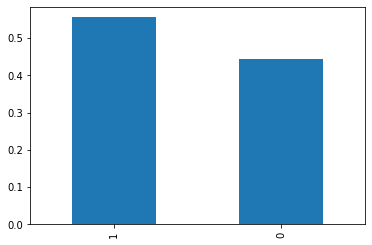

In [23]:
%%time
data_ohe = pd.DataFrame()
data_ohe = data_ohe.append(pd.get_dummies(df_Churn.fillna(0), drop_first=True))

target = data_ohe[целевой_признак]
features = data_ohe.drop(целевой_признак, axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
лучшее_повторение = 0.1
f1мера_1=0
print(f'F1-мера после перераспределения веса целевого признака: {f"{round(f1мера*100, 2)}%"}')
for i in np.arange(0.1, 1, 0.05):
#     print(i)
    gc.collect()
    features_downsampled, target_downsampled = downsample(features_train, target_train, i)
    model = LogisticRegression(solver='liblinear', random_state=12345)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    f1мера_1 = f1_score(target_valid, predicted_valid)
    if f1мера_1>f1мера:
        f1мера=f1мера_1
        лучшее_повторение = i
        features_train = features_downsampled.copy()
        target_train = target_downsampled.copy()
    del features_downsampled, target_downsampled
    gc.collect()
print(f'F1-мера после увеличения выборки: {f"{round(f1мера*100, 2)}%"}. Выборка уменьшена в {лучшее_повторение} раз.')
print(f'Распределение целевого признака {целевой_признак}')
class_frequency = pd.Series(target_train).value_counts(normalize=True)
display(class_frequency)
class_frequency.plot(kind='bar')

##### Промежуточный вывод
F1-мера все еще далека от 1. Путем снижения выборки особо ощутимого результата не наблюдается. Оставим способ увеличения выборки.

### Изменение порога

In [25]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
for threshold in np.arange(0, 1, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1мера = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1мера {:.3f}".format(
        threshold, precision, recall, f1мера))

Порог = 0.00 | Точность = 0.214, Полнота = 1.000, f1мера 0.353
Порог = 0.05 | Точность = 0.214, Полнота = 1.000, f1мера 0.353
Порог = 0.10 | Точность = 0.214, Полнота = 1.000, f1мера 0.353
Порог = 0.15 | Точность = 0.214, Полнота = 1.000, f1мера 0.353
Порог = 0.20 | Точность = 0.217, Полнота = 1.000, f1мера 0.356
Порог = 0.25 | Точность = 0.220, Полнота = 0.993, f1мера 0.360
Порог = 0.30 | Точность = 0.226, Полнота = 0.981, f1мера 0.367
Порог = 0.35 | Точность = 0.238, Полнота = 0.966, f1мера 0.382
Порог = 0.40 | Точность = 0.257, Полнота = 0.940, f1мера 0.403
Порог = 0.45 | Точность = 0.277, Полнота = 0.873, f1мера 0.420
Порог = 0.50 | Точность = 0.300, Полнота = 0.800, f1мера 0.437
Порог = 0.55 | Точность = 0.338, Полнота = 0.731, f1мера 0.462
Порог = 0.60 | Точность = 0.370, Полнота = 0.611, f1мера 0.461
Порог = 0.65 | Точность = 0.408, Полнота = 0.499, f1мера 0.449
Порог = 0.70 | Точность = 0.439, Полнота = 0.368, f1мера 0.400
Порог = 0.75 | Точность = 0.469, Полнота = 0.269, f1мер

##### Промежуточный вывод
В связи с тем, что F1-мера все еще далека от 1, можно увеличить точность в ущерб полноты, выставив порог в районе 0,6

Text(0.5, 1.0, 'ROC-кривая с площадью 0.72')

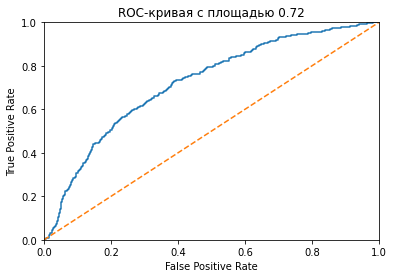

In [26]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC-кривая с площадью {round(auc_roc, 2)}')

##### Промежуточный вывод
Площать под ROC-кривой в районе 0,72, что означает, что модель предсказывает лучше, чем случайная модель.

##### Промежуточный вывод
Нужно искать способы улучшения модели.

### Попробую обучить случайный лес

In [51]:
%%time
data_ohe = pd.DataFrame()
data_ohe = data_ohe.append(pd.get_dummies(df_Churn.fillna(0), drop_first=True))
target = data_ohe[целевой_признак]
features = data_ohe.drop(целевой_признак, axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

scaler = StandardScaler()
scaler.fit(features_upsampled)

features_train = pd.DataFrame(data=scaler.transform(features_upsampled), columns=features_upsampled.columns)
features_valid = pd.DataFrame(data=scaler.transform(features_valid), columns=features_upsampled.columns)

CPU times: user 35.2 ms, sys: 101 µs, total: 35.3 ms
Wall time: 44.1 ms


In [56]:
%%time

# подбераю глубину леса при небольшом числе деревьев
лучшая_модель = None
лучший_результат = 0
лучшая_оценка = 0
f1мера = 0
# r2 = 0
auc_roc = 0
for depth in range(1, 101, 1):
    model = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=12345)
    model.fit(features_train, target_upsampled)
    predicted_valid = model.predict(features_valid)
    f1мера_1 = f1_score(target_valid, predicted_valid)
#     r2_1 = r2_score(target_valid, predicted_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc_1 = roc_auc_score(target_valid, probabilities_one_valid)
    if лучший_результат < f1мера_1:
        лучшая_модель = model
        лучший_результат = f1мера_1
        лучшая_оценка = depth
        f1мера = f1мера_1
        auc_roc = auc_roc_1
print(
#     "Точность (R2) наилучшей модели на валидационной выборке:", round(лучший_результат, 2)
      "Количество деревьев:", лучшая_оценка
#       , r2_описание(лучший_результат)
      , f'Площать под ROC-кривой {auc_roc}'
      , f'F1-мера: {f"{round(f1мера*100, 2)}%"}'
     )

Количество деревьев: 12 Площать под ROC-кривой 0.8529756723978027 F1-мера: 64.01%
CPU times: user 26.5 s, sys: 71 ms, total: 26.6 s
Wall time: 26.6 s


Деревьев 12
глубина: 30 Площать под ROC-кривой 0.8590506765594159 F1-мера: 64.31%
CPU times: user 6.49 s, sys: 20.3 ms, total: 6.51 s
Wall time: 6.52 s


Text(0.5, 1.0, 'ROC-кривая с площадью 0.86')

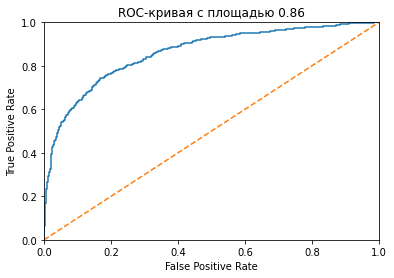

In [61]:
%%time
лучшая_глубина = 20
print(f'Деревьев {лучшая_оценка}')
for n_estimators in range(20, 101, 10):
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=лучшая_оценка,  random_state=12345)
    model.fit(features_train, target_upsampled)
    predicted_valid = model.predict(features_valid)
    f1мера_1 = f1_score(target_valid, predicted_valid)
#     r2_1 = r2_score(target_valid, predicted_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc_1 = roc_auc_score(target_valid, probabilities_one_valid)
    if лучший_результат < f1мера_1:
        лучшая_модель = model
        лучший_результат = f1мера_1
        лучшая_глубина = n_estimators
        f1мера = f1мера_1
        auc_roc = auc_roc_1
print(
#     "Точность (R2) наилучшей модели на валидационной выборке:", round(лучший_результат, 2)
      "глубина:", лучшая_глубина
#       , r2_описание(лучший_результат)
      , f'Площать под ROC-кривой {auc_roc}'
      , f'F1-мера: {f"{round(f1мера*100, 2)}%"}'
     )
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC-кривая с площадью {round(auc_roc, 2)}')

##### Промежуточный вывод
Удалось достичь величину меры f1 64.01% при 12 деревьев и ветвей. Площадь под  ROC-кривой 0,85 что говорит о том, что модель стала предсказывать гораздо лучше.Коэффициент детерминации вырас больше нулевого значения. Так же был сделан тест на большом количестве деревьев (5000) и ветвей (10000), такое увеличение не привело к существенному улучшению метрик, а длительнсть обучения сильно возросла.

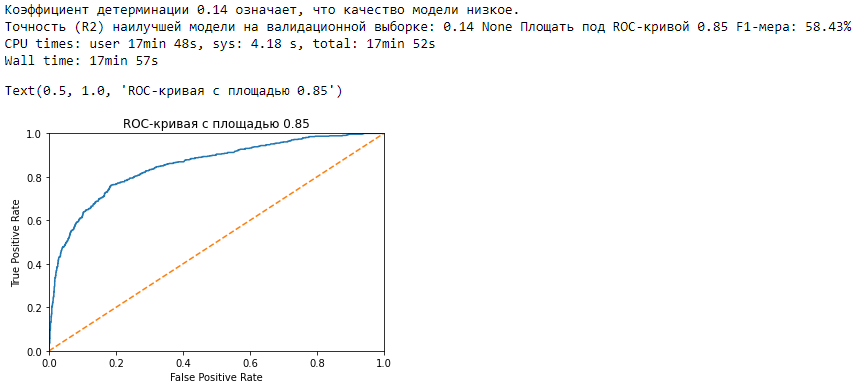

## Проведите финальное тестирование.

In [63]:
%%time
data_ohe = pd.DataFrame()
data_ohe = data_ohe.append(pd.get_dummies(df_Churn.fillna(0), drop_first=True))
target = data_ohe[целевой_признак]
features = data_ohe.drop(целевой_признак, axis=1)
features_train, fv, target_train, ft = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
features_valid, features_test, target_valid, target_test = train_test_split(
    fv, ft, test_size=0.5, random_state=12345)

scaler = StandardScaler()
scaler.fit(features_upsampled)

features_train = pd.DataFrame(data=scaler.transform(features_upsampled), columns=features_upsampled.columns)
features_valid = pd.DataFrame(data=scaler.transform(features_valid), columns=features_upsampled.columns)
features_test = pd.DataFrame(data=scaler.transform(features_test), columns=features_upsampled.columns)

CPU times: user 33.9 ms, sys: 62 µs, total: 34 ms
Wall time: 31.8 ms


Площать под ROC-кривой 0.84 F1-мера: 60.36%
CPU times: user 315 ms, sys: 7.87 ms, total: 323 ms
Wall time: 321 ms


Text(0.5, 1.0, 'ROC-кривая с площадью 0.84')

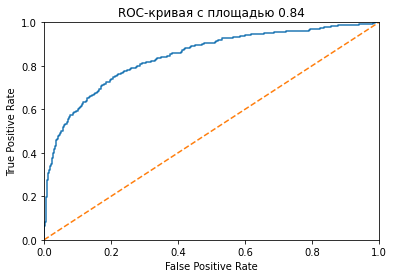

In [64]:
%%time

# model = RandomForestClassifier(n_estimators=200, max_depth=500,  random_state=12345, class_weight='balanced')
model = RandomForestClassifier(n_estimators=30, max_depth=12,  random_state=12345, class_weight='balanced')
model.fit(features_train, target_upsampled)

predicted_valid = model.predict(features_valid)
f1мера = f1_score(target_valid, predicted_valid)
# r2 = r2_score(target_valid, predicted_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(
#     "Точность (R2) на валидационной выборке:", round(r2, 2)
#       , r2_описание(r2)
      f'Площать под ROC-кривой {round(auc_roc, 2)}'
      , f'F1-мера: {f"{round(f1мера*100, 2)}%"}'
     )
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC-кривая с площадью {round(auc_roc, 2)}')




Площать под ROC-кривой 0.85 F1-мера: 62.04%


Text(0.5, 1.0, 'ROC-кривая с площадью 0.85')

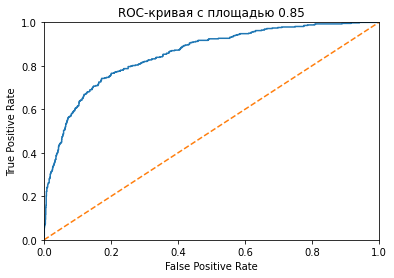

In [65]:
# model = RandomForestClassifier(n_estimators=200, max_depth=500,  random_state=12345, class_weight='balanced')
model = RandomForestClassifier(n_estimators=30, max_depth=12,  random_state=12345, class_weight='balanced')
model.fit(features_train.append(features_valid), target_upsampled.append(target_valid))

predicted_valid = model.predict(features_test)
f1мера = f1_score(target_test, predicted_valid)
# r2 = r2_score(target_valid, predicted_valid)
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_valid)

print(
#     "Точность (R2) на тестовой выборке:", round(r2, 2)
#       , r2_описание(r2)
      f'Площать под ROC-кривой {round(auc_roc, 2)}'
      , f'F1-мера: {f"{round(f1мера*100, 2)}%"}'
     )
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC-кривая с площадью {round(auc_roc, 2)}')

## Вывод
При изучении параметров наилучший результат показателя F1-меры 60.36% был достигнут на валидационной выборке для модели случайного леса. На тестовой выборке при переобучении модели на валидационной + тренировочной выборках показатель подрос до 62.04%.<br>
Модель леса на тестовой выборке, как и модель регрессии ведут себя лучше чем случайная модель, где площадь под ROC-кривой больше 0.8.<br>
Для улучшения прогнозирования можно:<br>
 - обогатить источник данных дополнительной информацией
 - увеличить выборку, возможно 10000 строк мало для проведения всех испытаний.